In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Function definitions

In [2]:
def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig

# Reading in data

In [3]:
%%time
df_10s = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_10s.csv', delimiter='\t', parse_dates=['datetime'])
#df_10s = df_10s.set_index(['datetime'])

CPU times: user 1min 40s, sys: 11.3 s, total: 1min 52s
Wall time: 1min 54s


In [4]:
df = reduce_memory(df_10s) # converts float64 to float32

100%|██████████| 25/25 [00:41<00:00,  1.67s/it]

Memory uasge reduced from 6.478 GB to 3.498 GB


In [5]:
df.columns

Index(['datetime', 'eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn',
       'ePower', 'ePowerReturn', 'gasMeter', 'gasPower', 'DD', 'DR', 'FF',
       'FX', 'N', 'P', 'Q', 'RG', 'SQ', 'T', 'T10', 'TD', 'U', 'VV', 'WW',
       'dwelling'],
      dtype='object')

In [6]:
t = df.set_index(['datetime'])

# EDA on daily mean data

In [7]:
%%time
t = t.dropna()
day = t.resample('24H').mean()
day = day.dropna()

CPU times: user 18.5 s, sys: 7.68 s, total: 26.1 s
Wall time: 26.2 s


Saving heatmap
CPU times: user 152 ms, sys: 6.88 ms, total: 159 ms
Wall time: 186 ms


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

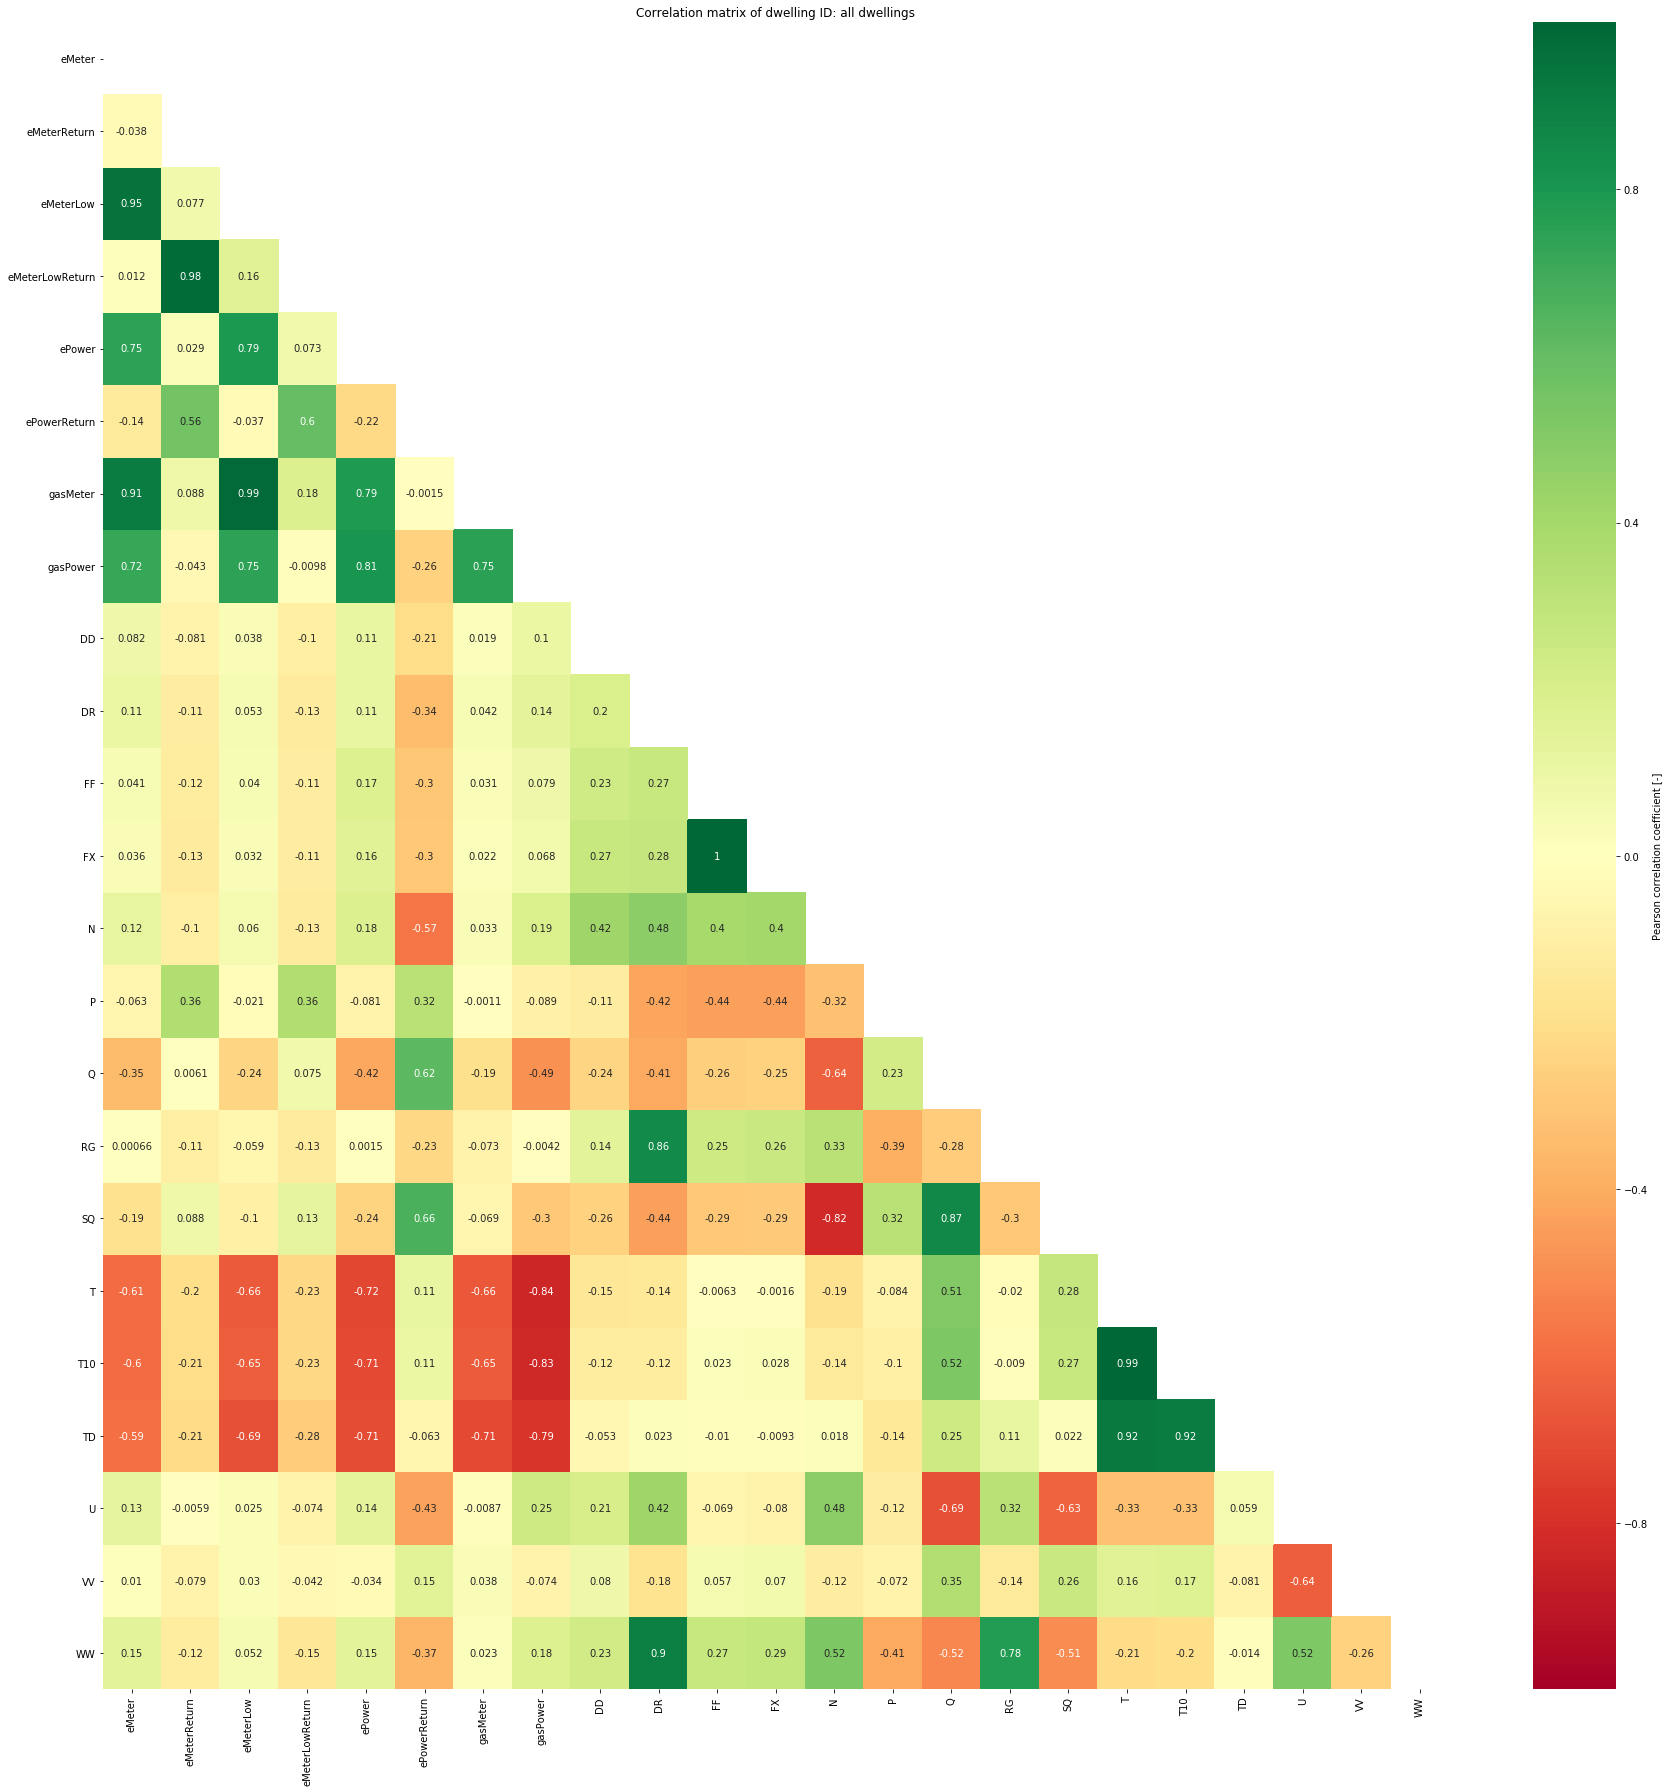

In [8]:
%%time
fig = create_corr_matrix(day, 'all dwellings', True)

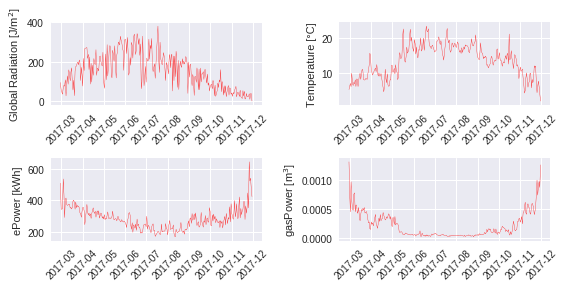

In [9]:
sns.set()

def datetime_layout():
    plt.xticks(rotation=45)
    #plt.grid()
    plt.tight_layout()

x = day.index

plt.subplot(3,2,1)
plt.plot(x, day['Q'], '-', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('Global Radiation [J/m$^2$]')
datetime_layout()

plt.subplot(3,2,2)
plt.plot(x, day['T'], '-', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('Temperature [°C]')
datetime_layout()

plt.subplot(3,2,3)
plt.plot(x, day['ePower'], '-', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('ePower [kWh]')
datetime_layout()

plt.subplot(3,2,4)
plt.plot(x, day['gasPower'], '-', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('gasPower [m$^3$]')
datetime_layout()

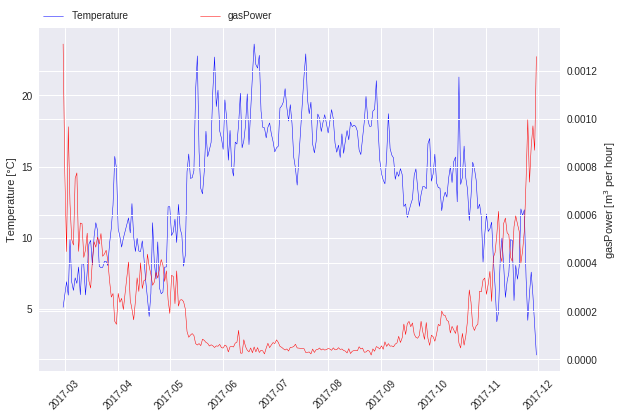

In [10]:
fig, ax = plt.subplots()
datetime_layout()

ax.plot(x, day['T'], 'b-', linewidth=0.5, label='Temperature')
ax.set_ylabel('Temperature [°C]')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), borderaxespad=0, frameon=False) # Put legend on custom location
# more legend info: https://jdhao.github.io/2018/01/23/matplotlib-legend-outside-of-axes/

ax = ax.twinx() 
ax.plot(x, day.gasPower, 'r-', linewidth=0.5, label='gasPower')
ax.set_ylabel('gasPower [m$^3$ per hour]')

ax.legend(loc='lower left', bbox_to_anchor= (0.3, 1.01), borderaxespad=0, frameon=False)

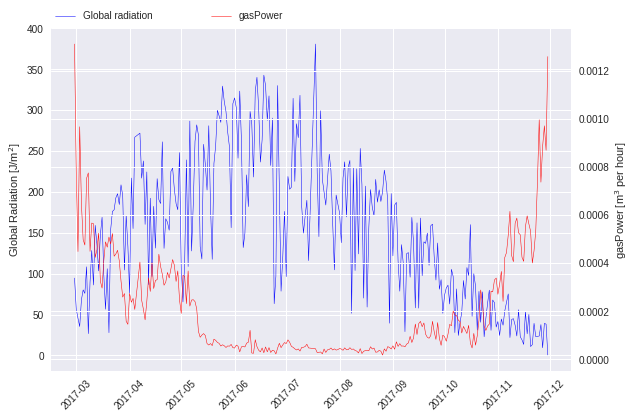

In [11]:
fig, ax = plt.subplots()
datetime_layout()

ax.plot(x, day['Q'], 'b-', linewidth=0.5, label='Global radiation')
ax.set_ylabel('Global Radiation [J/m$^2$]')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), borderaxespad=0, frameon=False) # Put legend on custom location
# more legend info: https://jdhao.github.io/2018/01/23/matplotlib-legend-outside-of-axes/

ax = ax.twinx() 
ax.plot(x, day.gasPower, 'r-', linewidth=0.5, label='gasPower')
ax.set_ylabel('gasPower [m$^3$ per hour]')

ax.legend(loc='lower left', bbox_to_anchor= (0.3, 1.01), borderaxespad=0, frameon=False)

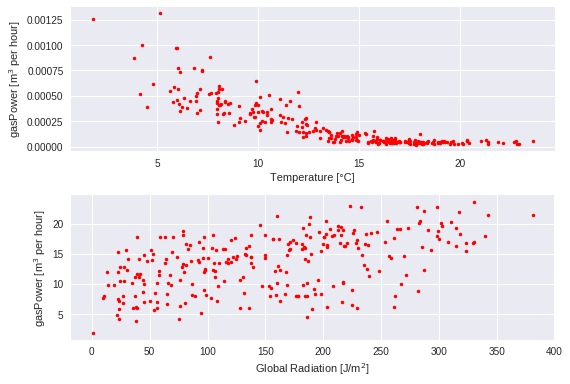

In [12]:
plt.subplot(2,1,1)
plt.plot(day['T'], day['gasPower'], '.', color='r', linewidth=0.3)
plt.ylabel('gasPower [m$^3$ per hour]')
plt.xlabel('Temperature [°C]')
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(day['Q'], day['T'], '.', color='r', linewidth=0.3)
plt.ylabel('gasPower [m$^3$ per hour]')
plt.xlabel('Global Radiation [J/m$^2$]')
plt.tight_layout()

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.23,'1 Day mean of all dwellings')

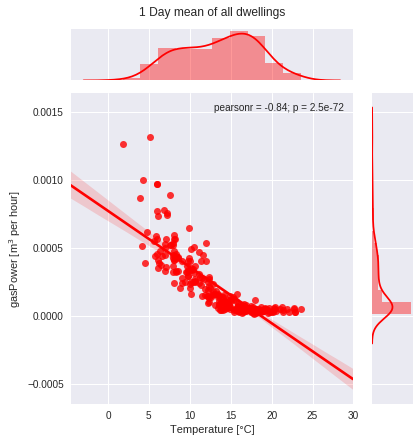

In [13]:
fig = sns.jointplot(x="T", y="gasPower", data=day, kind="reg", color='r')
sns.plt.ylabel('gasPower [m$^3$ per hour]')
sns.plt.xlabel('Temperature [°C]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of all dwellings', y=1.23)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.23,'1 Day mean of all dwellings')

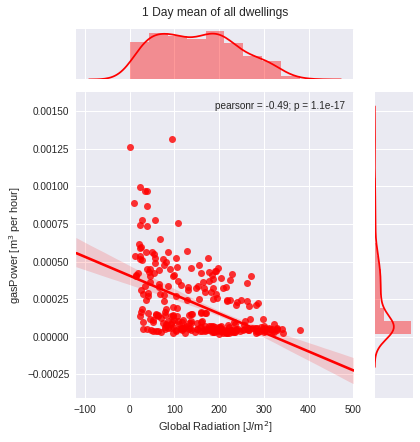

In [14]:
fig = sns.jointplot(x="Q", y="gasPower", data=day, kind="reg", color='r')
sns.plt.ylabel('gasPower [m$^3$ per hour]')
sns.plt.xlabel('Global Radiation [J/m$^2$]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of all dwellings', y=1.23)

Text(0.5,0,'gasPower')

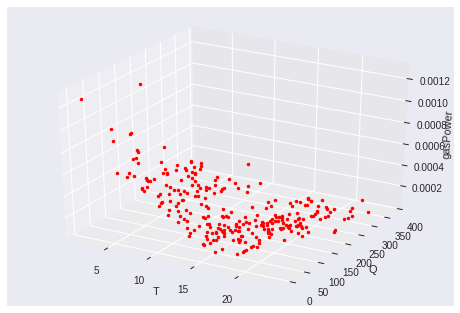

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(day['T'], day['Q'], day['gasPower'], '.', color='r')

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

Text(0.5,0,'gasPower')

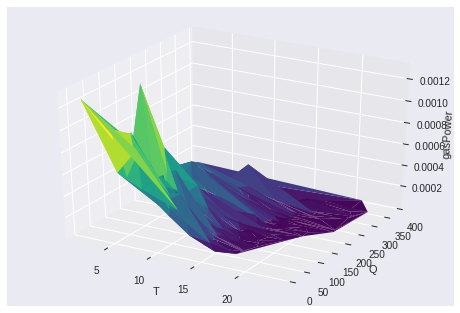

In [16]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(day['T'], day['Q'], day['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Multivariable linear regression: predict gasPower

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Nobody turns on their heating when T > 19?, so deselect this data
data = day[day['T'] < 19]



#X = filtered.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
X = data[['T', 'Q']]
print('X columns: %s' % list(X.columns))
y = data['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['T', 'Q']


0.77300115078723042

Text(0.5,0,'gasPower')

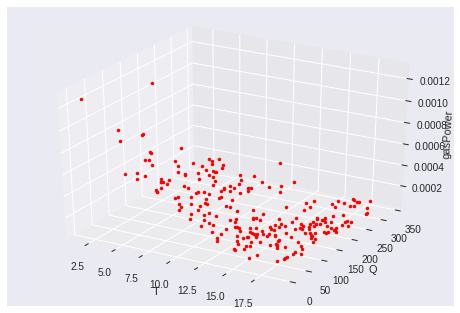

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data['T'], data['Q'], data['gasPower'], '.', color='r')

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

Text(0.5,0,'gasPower')

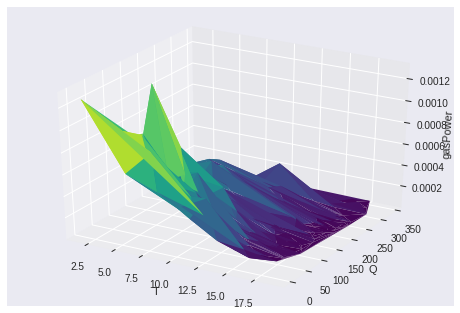

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data['T'], data['Q'], data['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Multivariable linear regression: predict gasPower with more variables

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = day[day['T'] < 19]

X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['ePower', 'ePowerReturn', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


0.869056234403075

This is quite high....

In [21]:
model.coef_

array([[  1.09879591e-06,  -8.05934576e-07,   2.01520862e-08,
         -1.85140834e-07,  -6.46427270e-06,   7.82622820e-08,
         -3.26596346e-05,  -3.67122921e-05,   1.01051978e-06]], dtype=float32)

# Multivariable linear regression: predict ePower

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = day[day['T'] < 19]

X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','ePower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data['ePower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['gasPower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


0.6494359218086827

In [23]:
model.coef_

array([[  1.48694609e+05,  -3.82129438e-02,   3.38594389e+00,
          2.29665637e+00,  -4.51451838e-02,   7.12998033e-01,
         -4.38919973e+00,  -7.33409047e-01]], dtype=float32)

# Deep learning
## Initialize tensorflow setup

In [24]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Preprocessing data

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data = day[day['T'] < 19]
epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

In [31]:
# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['gasPower']]

X columns: ['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


In [32]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (48, 8)
X_test shape: (193, 8)
y_train shape: (48, 1)
y_test shape: (193, 1)

X_train variance 1.00807805953
y_train variance 1.12098399425


# Create the keras model

In [34]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(8, input_shape=(8,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

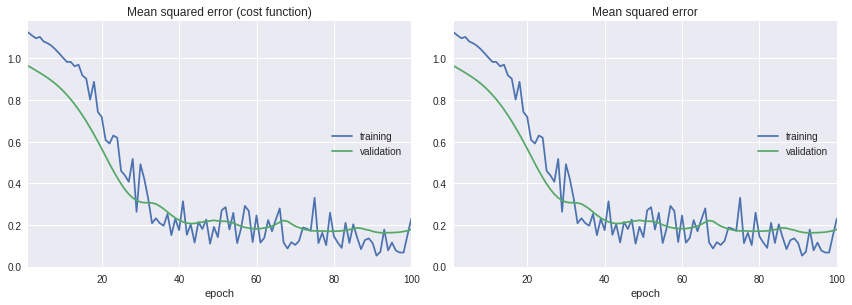

 - 0s - loss: 0.2302 - mean_squared_error: 0.2302 - val_loss: 0.1784 - val_mean_squared_error: 0.1784


In [35]:
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=100)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)), epochs=100, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

How to interpret mean squared error:  
`The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.`  
https://en.wikipedia.org/wiki/Mean_squared_error

# Keras on higher resolution data
## Preprocessing data

In [156]:
%%time
data = df
data = data.set_index(['datetime'])
data = data.resample('4H').mean()

CPU times: user 12.7 s, sys: 13.1 s, total: 25.8 s
Wall time: 24 s


In [157]:
"""
Create columns with time information. 
The idea is that the neural network will start taking time into account also.
"""
data['hour'] = data.index.hour
#data['minute'] = data.index.minute
#data['second'] = data.index.second
data = data.dropna()
data.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,gasPower,DD,DR,...,Q,RG,SQ,T,T10,TD,U,VV,WW,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 08:00:00,2328.599854,0.0,2944.616943,0.0,178.474457,0.0,2185.584961,0.000000,221.716675,235.000000,...,46.583332,0.650000,0.588150,4.412500,3.933333,2.650000,87.958336,26248.750000,47.291668,8
2017-02-28 12:00:00,2329.129883,0.0,2944.616943,0.0,262.311981,0.0,2186.732910,0.001183,219.831818,0.000000,...,164.652176,0.000000,0.797791,5.321739,5.495652,2.430435,81.260872,43947.824219,1.750000,12
2017-02-28 16:00:00,2331.096924,0.0,2944.616943,0.0,735.140381,0.0,2189.001709,0.001687,242.216660,0.000000,...,117.416664,0.000000,4.372154,5.325000,5.033333,1.900000,78.166664,43395.832031,1.875000,16
2017-02-28 20:00:00,2333.105713,0.0,2945.258301,0.0,511.037628,0.0,2190.546387,0.000852,218.666672,0.000000,...,0.083333,0.000000,0.000000,4.770833,3.841667,1.795833,80.625000,40866.667969,2.250000,20
2017-03-01 00:00:00,2333.165039,0.0,2946.494629,0.0,160.278946,0.0,2191.084473,0.000099,193.310867,85.565216,...,0.760870,0.191304,0.000000,4.200000,3.863044,2.389130,87.565216,29619.564453,15.782609,0


In [158]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['gasPower']]

X columns: ['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U', 'hour']


In [159]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (322, 9)
X_test shape: (1289, 9)
y_train shape: (322, 1)
y_test shape: (1289, 1)

X_train variance 0.991741590446
y_train variance 0.694313753998


# Creating the model

In [161]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(9, input_shape=(9,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

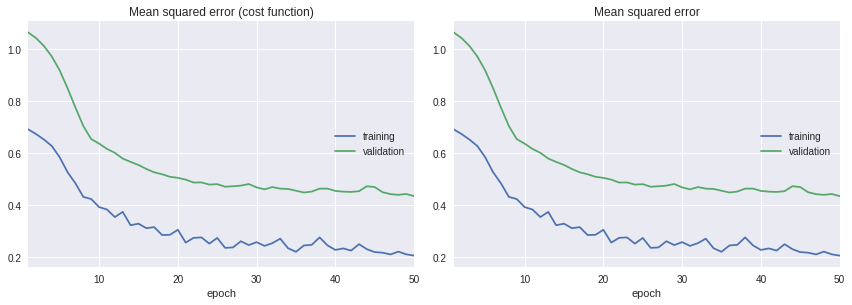

 - 0s - loss: 0.2047 - mean_squared_error: 0.2047 - val_loss: 0.4333 - val_mean_squared_error: 0.4333
CPU times: user 33.5 s, sys: 2.48 s, total: 36 s
Wall time: 22.8 s


In [162]:
%%time
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=5000)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)/10), epochs=50, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

Higher resolution will give worse results (But why? The hour column is there...)

# Do the same, but to predict energy usage
## Preprocessing

In [165]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'ePower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['ePower']]

X columns: ['gasPower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U', 'hour']


In [166]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (322, 9)
X_test shape: (1289, 9)
y_train shape: (322, 1)
y_test shape: (1289, 1)

X_train variance 0.955527843526
y_train variance 1.02264132679


# Create the model

In [171]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(9, input_shape=(9,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

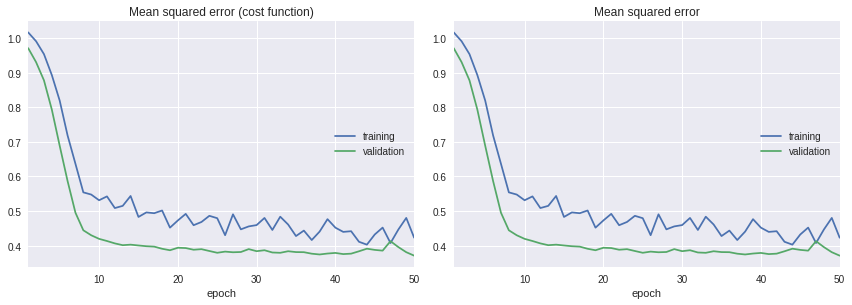

 - 0s - loss: 0.4229 - mean_squared_error: 0.4229 - val_loss: 0.3709 - val_mean_squared_error: 0.3709
CPU times: user 38.5 s, sys: 4.97 s, total: 43.4 s
Wall time: 23.7 s


In [172]:
%%time
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=100)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)/10), epochs=50, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])